## Exercise 1
given the following un-normalized posterior distribution 

$ g(\theta|x) \propto \frac{1}{2} \exp\left(-\frac{(\theta + 3)^2}{2}\right) + \frac{1}{2} \exp\left(-\frac{(\theta - 3)^2}{2}\right) $

Please note that LaTeX is a typesetting language commonly used for mathematical expressions. It provides a more standardized and visually appealing representation of mathematical equations. <br>
a) draw a Markov Chain from the posterior distribution using a Metropolis-Hastings algorithm <br>
b) use a Norm (0, 1) as random-walk candidate density<br>
c) plot the sampled distribution<br>
d) analyze the chain with the CODA package and plot the chain autocorrelation<br>
e) try to use different burn-in cycles and thinning and plot the corresponding posterior distribution<br>
and the chain autocorrelation function. What are the best parameters ?<br>

a,b,c) I draw a Markov Chain from the g function using a Metropolis-Hastings algorithm. The simulation starts with a burn-in phase and after that the code proceeds to the main sampling loop where the Metropolis algorithm is applied to generate the desired number of samples. For each iteration in the algorithm, a new proposed value for theta is generated using a normal distribution with mean theta.cur and standard deviation sigma.
The Metropolis ratio is calculated as the base 10 logarithm of the ratio between the probability density at the new proposed point (func.Prop) and the probability density at the current point (func.Cur).
The Metropolis ratio is then compared to a random value drawn from a uniform distribution between 0 and 1. If the Metropolis ratio is greater than or equal to 0 or greater than the base 10 logarithm of the randomly drawn value, the new proposed point is accepted as the new current point; otherwise, the current point is retained. 

In [2]:
library (coda)

In [7]:
#define the prior function
g <- function(theta) {
    return(0.5 * exp(-((theta + 3)^2) / 2) + 0.5 * exp(-((theta - 3)^2) / 2))
}

# gets the log10 of g function
g.metropolis <- function (theta) {
return (log10(g(theta)))
}

metropolis_1dim <- function(func, theta.init, n.sample, n.burn.in, sigma, show = FALSE) {
  
  theta.cur <- theta.init
  func.Cur <- func(theta.cur)
  func.Samp <- matrix(data = NA, nrow = n.sample, ncol = 2)
  n.accept <- 0
  
  for (burn in 1:n.burn.in) {
    theta.prop <- rnorm(n = 1, mean = theta.cur, sigma)  # proposed value for theta
    func.Prop <- func(theta.prop)
    logMR <- func.Prop - func.Cur
    if (logMR >= 0 || logMR > log10(runif(1))) {
      n.accept <- n.accept + 1
    }
  }
  
  for (n in 1:n.sample) {
    theta.prop <- rnorm(n = 1, mean = theta.cur, sigma)  # proposed value for theta
    func.Prop <- func(theta.prop)
    logMR <- func.Prop - func.Cur
    if (logMR >= 0 || logMR > log10(runif(1))) {
      theta.cur <- theta.prop
      func.Cur <- func.Prop
      n.accept <- n.accept + 1
    }
    func.Samp[n, 1] <- func.Cur
    func.Samp[n, 2] <- theta.cur
  }
  
  acceptance_rate <- 100 * n.accept / n.sample
  
  if (show) {
    print(paste("Acceptance Rate:", acceptance_rate, "%"))
  }
  
  return(func.Samp)
}


In [19]:
#set simulation parameters
theta.init <- -20
sample.sig <- 8
n.sample <- 10^6
n.burn.in <- 100

#run the MCMC simulation
set.seed(20190513)
chain <- metropolis_1dim(func= g.metropolis , theta.init = theta.init ,
                                                   n.sample = n.sample , n.burn.in=n.burn.in,sigma = sample.sig**2, show=FALSE)

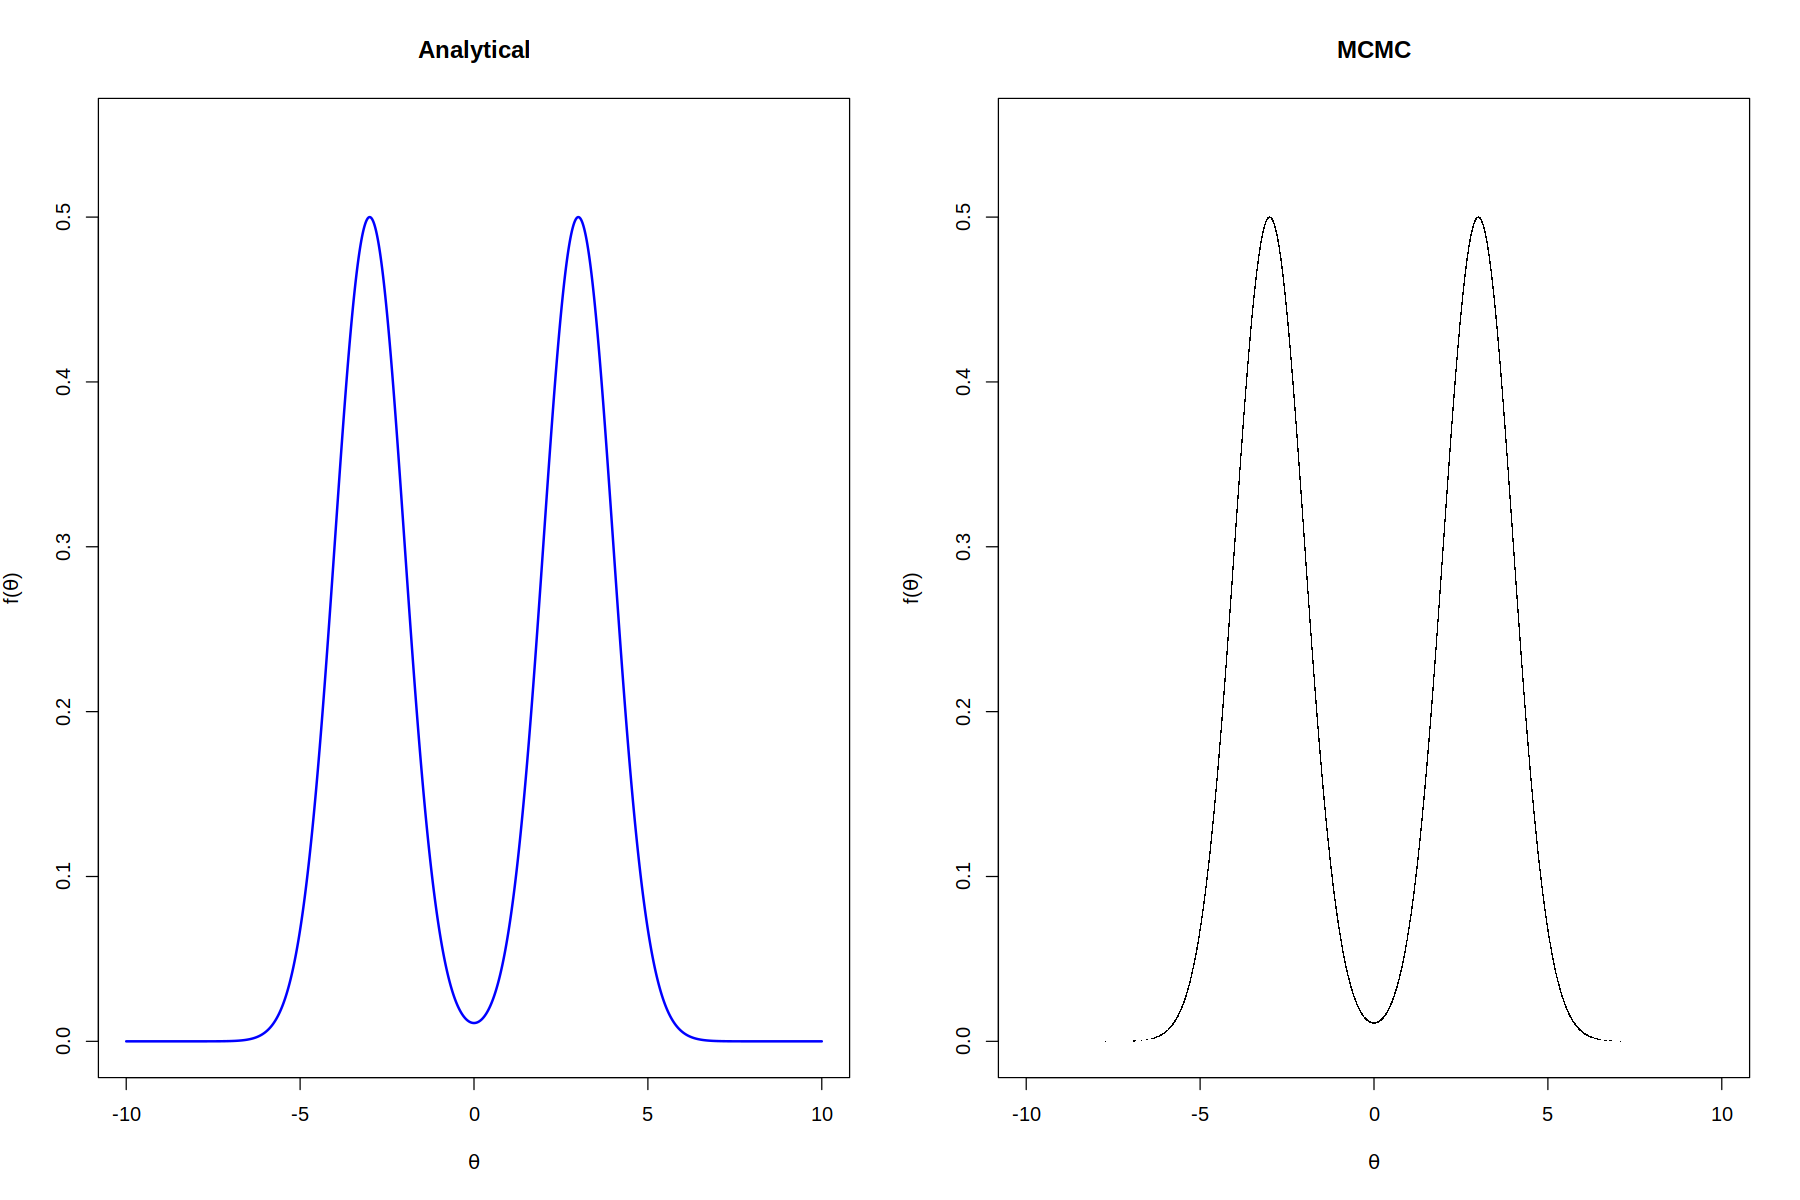

In [20]:
#plot the g function
par( mfrow=c(1,2))
options(repr.plot.width = 15, repr.plot.height = 10)
x <- seq(-10, 10, length.out=10**4)
y <- g(x)
ymax <- 1.05 * max(y)
plot(x, y, ylim=c(0,max(y)*1.10), type='l', lwd=2, col='blue', main='Analytical', xlab= expression(theta), ylab = expression( paste ('f(',theta ,')', sep='')))

#plot the sampled points from g
Y <- chain[, 1]
X <- chain[, 2]
plot(X, 10**Y, type='p', pch='.', col='black', xlim=c(-10,10), ylim=c(0,max(y)*1.10), main='MCMC', xlab= expression(theta), ylab = expression( paste ('f(',theta ,')', sep='')))

In [39]:
sa <- which(chain[,2]>= min(x) & chain[,2]<= max(x)) #prende quelli tra -10 e 10
hist <- hist(chain[sa ,2], breaks =seq(from=min(x), to=max(x), length.out=100), plot= FALSE)
Zhist <- sum(hist$counts )* diff(range(hist$breaks ))/( length (hist$counts ))
Zfunc <- sum(y)
Zfunc

[1] 1253.189

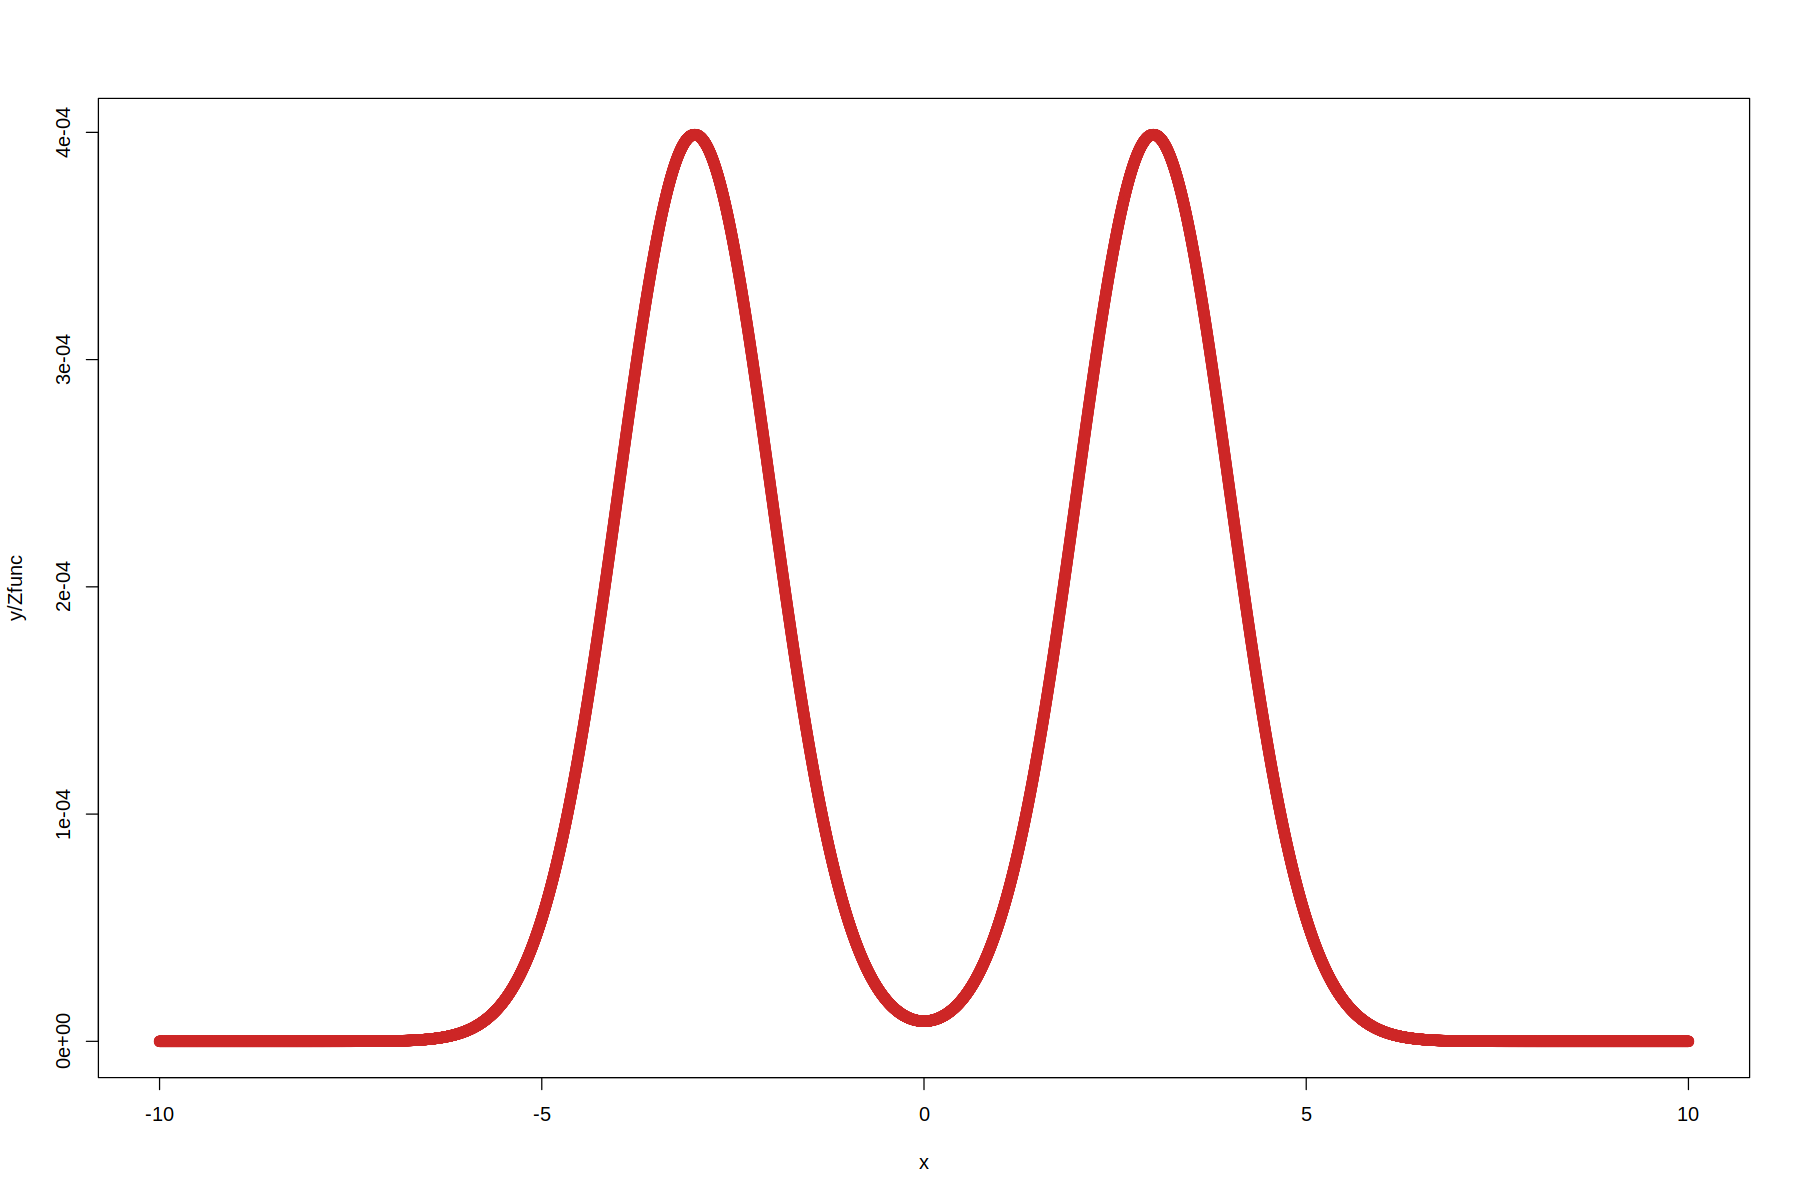

In [40]:
#plot(hist$breaks, c(hist$counts/Zhist ,0), col='navy', type="s", lwd=2, lty=5)
plot(x, y/Zfunc, col='firebrick 3', lty=1, lwd = 2)

d) analyze the chain with the CODA package and plot the chain autocorrelation. <br>
I create a sequence of lags from 0 to 500 to represent the time intervals at which the autocorrelation will be computed. I compute the autocorrelation function (ACF) for the chain and I visualize the results in a scatter plot. Since the autocorrelation measures how closely the chain is correlated with itself h steps later, if the autocorrelation is small at higher lag times, it indicates that the current sample is not significantly influenced by its past samples, implying that the samples are approximately independent. This indicates that the chain has reached a convergence and the generated samples are representative of the target distribution.

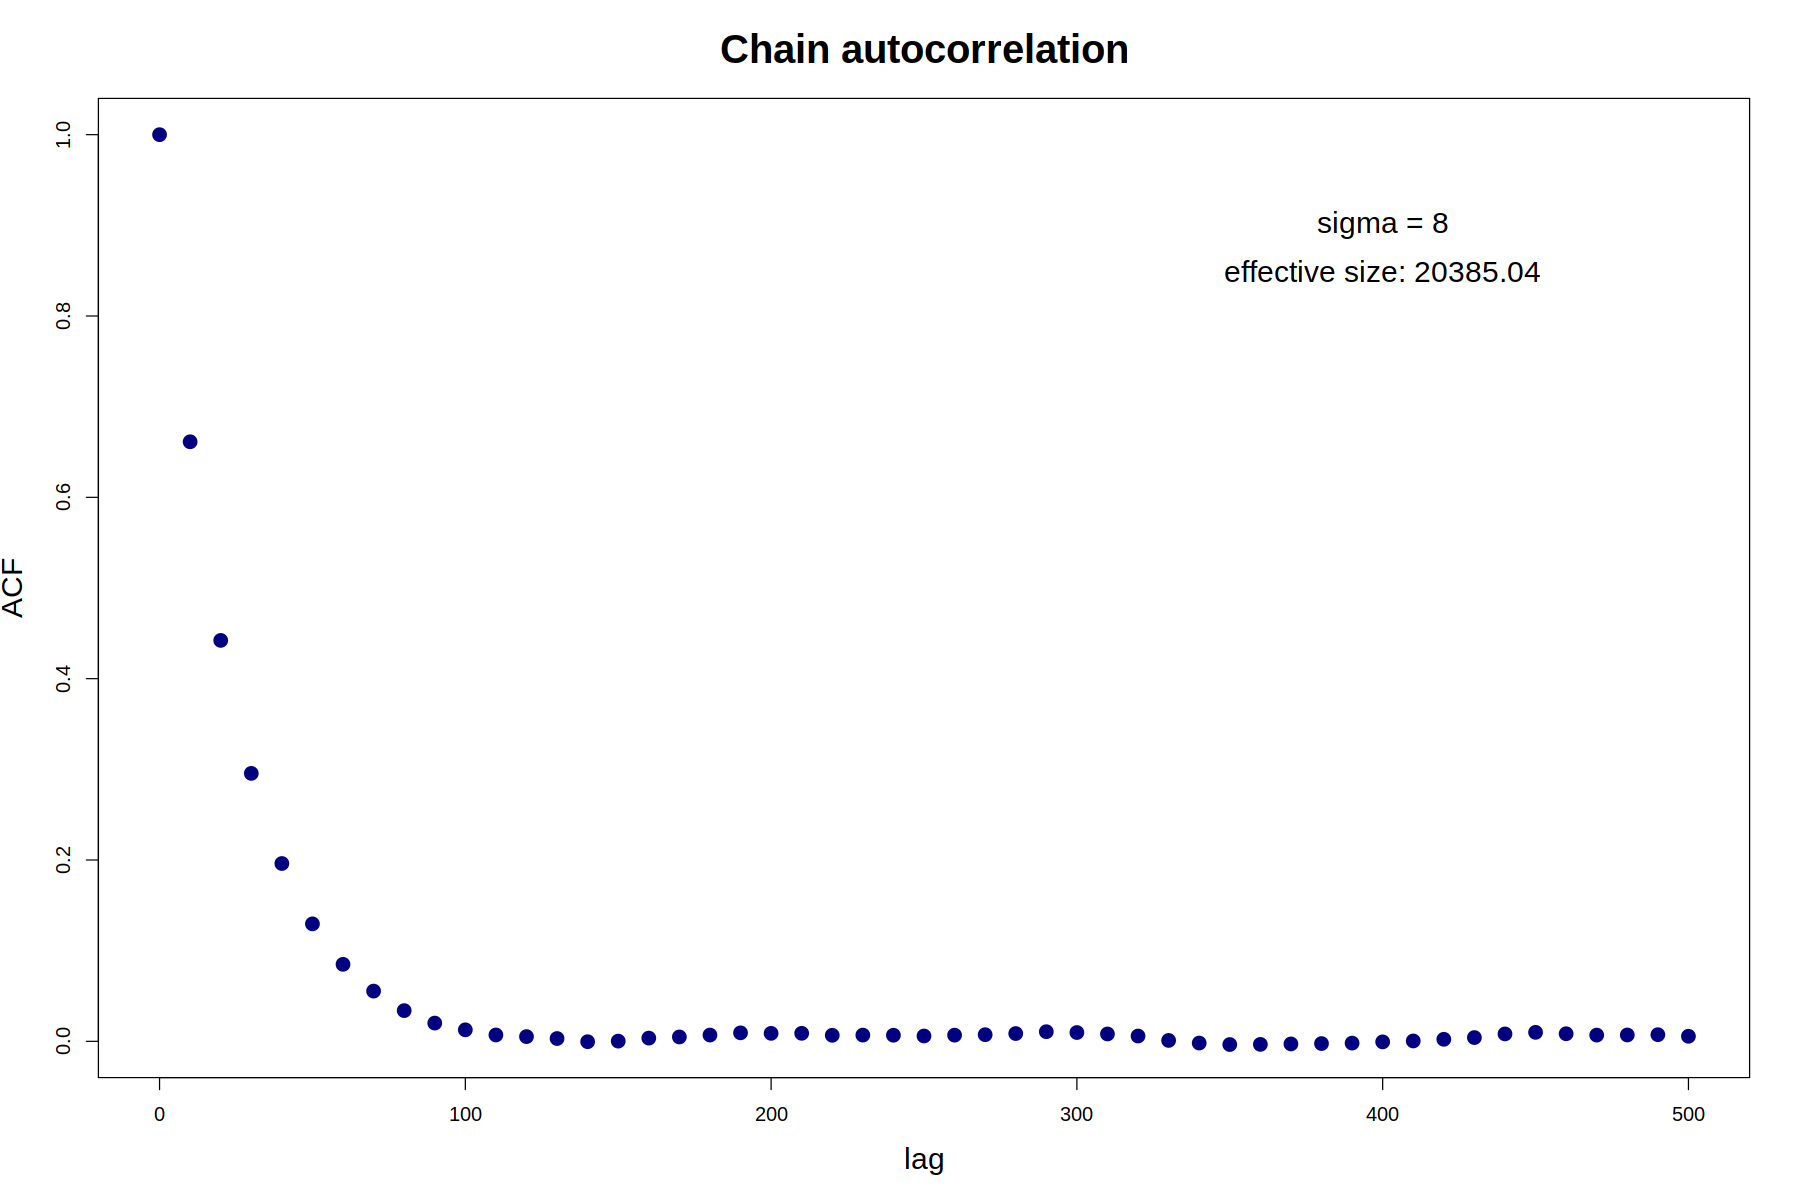

In [10]:
chain1 <- as.mcmc(chain[,2])
my.lags = seq(0,500,10)
y1 <- autocorr(chain1, lags=my.lags)
plot(my.lags, y1, ylim=c(0, 1), pch=19, col='navy', xlab='lag', ylab='ACF', main = 'Chain autocorrelation',cex=1.5,cex.lab=1.5, cex.main=2)
text(400, 0.9, paste('sigma = 8'), cex=1.5)
text(400, 0.85, sprintf("effective size: %.2f", effectiveSize(chain1)), cex=1.5)


e) try to use different burn-in cycles and thinning and plot the corresponding posterior distribution
and the chain autocorrelation function. What are the best parameters ?

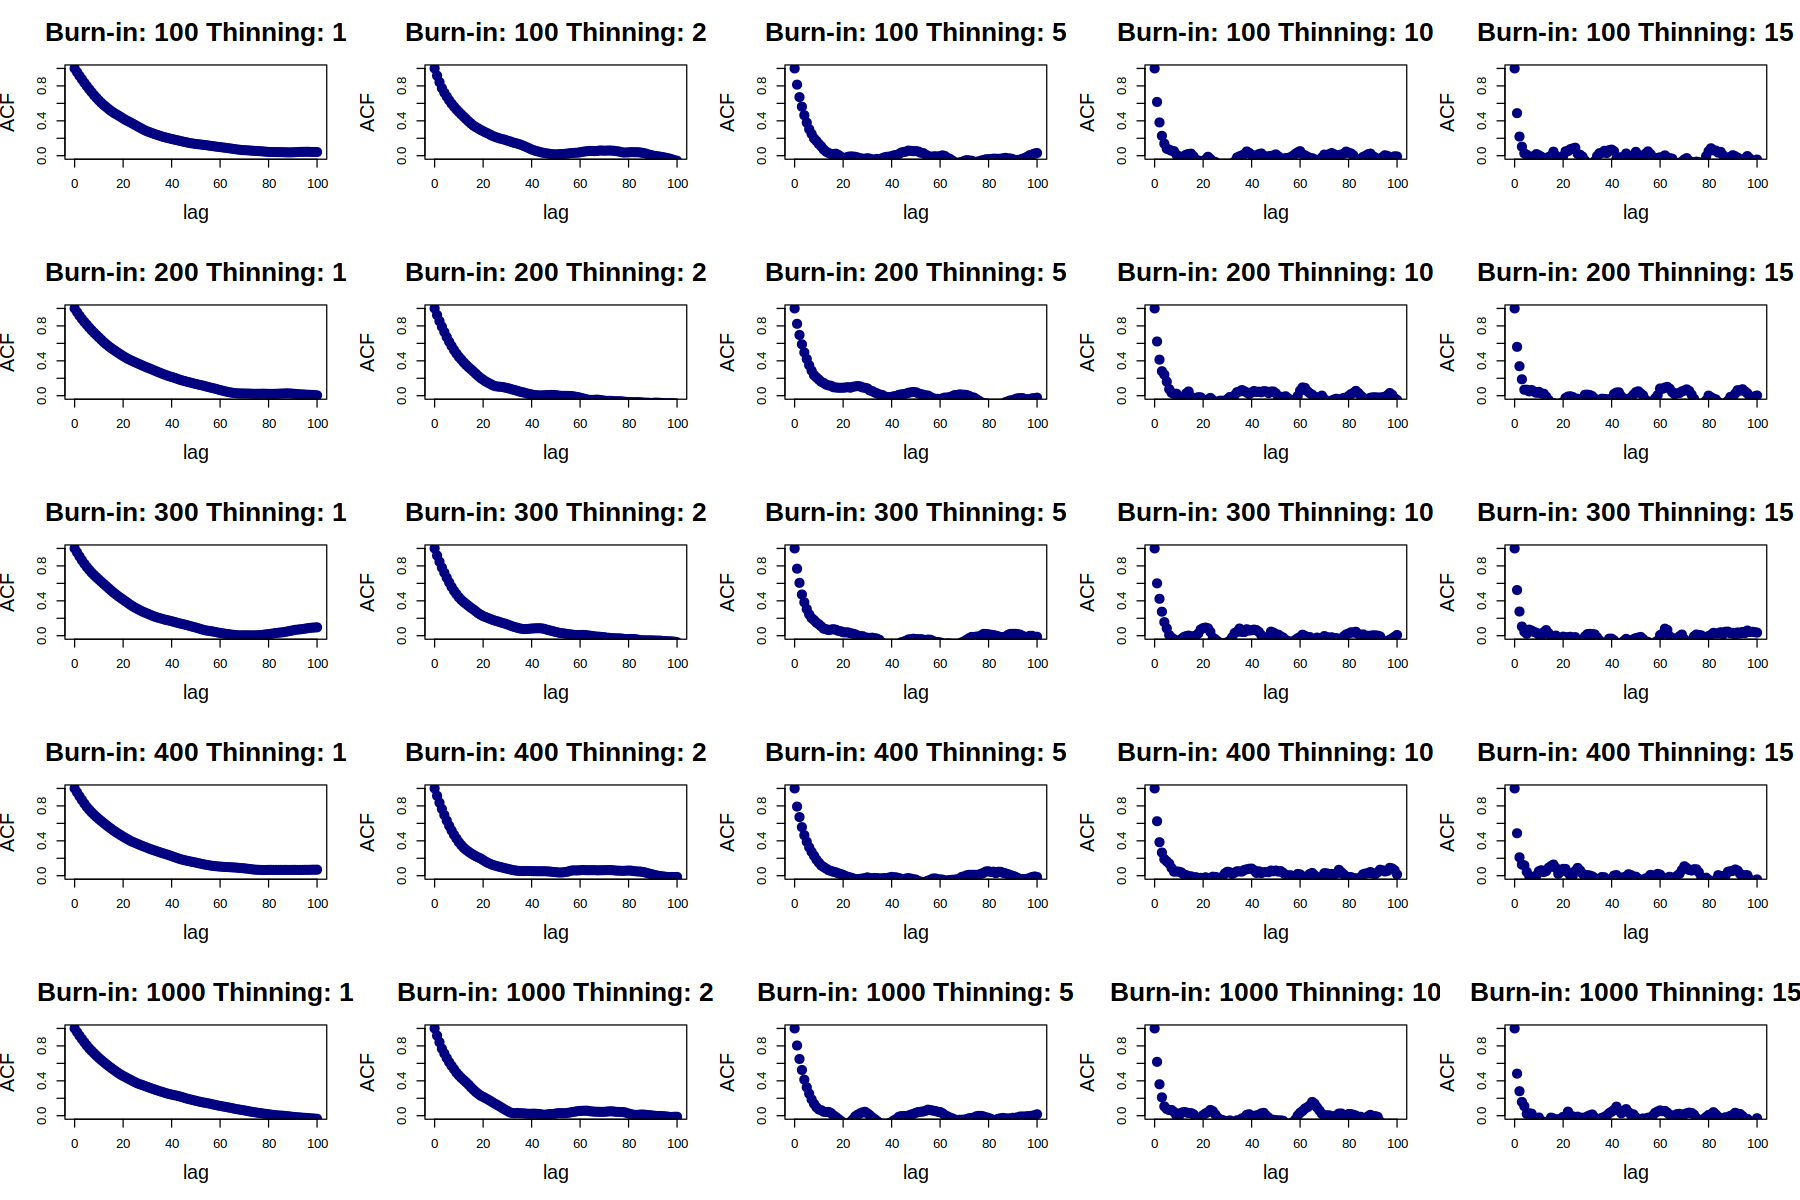

In [24]:
n.burn.in.values <- c(100, 200, 300, 400, 1000)  # Different burn-in values
thinning.values <- c(1, 2, 5, 10, 15)  # Different thinning values

par(mfrow = c(length(n.burn.in.values), length(thinning.values)))  # Set up the layout for the plots

for (i in 1:length(n.burn.in.values)) {
  n.burn.in <- n.burn.in.values[i]
  
  for (j in 1:length(thinning.values)) {
    interval <- thinning.values[j]
    
    #simulation
      n.sample <- 10^4
    chain <- metropolis_1dim(func = g.metropolis, theta.init = theta.init,
                             n.sample = n.sample, n.burn.in = n.burn.in, sigma = sample.sig**2,  show = FALSE)

    #thinning
    chain_thin <- chain[seq(1, nrow(chain), by = interval), ]
    X_thin <- chain_thin[, 2]
    Y_thin <- chain_thin[, 1]

    #autocorrelation
    chain1 <- as.mcmc(chain_thin[, 2])
    my.lags <- seq(0, 100, 1)
    y1 <- autocorr(chain1, lags = my.lags)
    
    #plot autocorrelation
    plot(my.lags, y1, ylim = c(0, 1), pch = 19, col = 'navy', xlab = 'lag', ylab = 'ACF',
         main = paste("Burn-in:", n.burn.in, "Thinning:", interval), cex = 1.5, cex.lab = 1.5, cex.main = 2)
    text(400, 0.9, paste('sigma = 8'), cex = 1.5)
    text(400, 0.85, sprintf("effective size: %.2f", effectiveSize(chain1)), cex = 1.5)
  }
}


## plot the corrisonding posterior distribution for last point!!!!!!!!!!!!!!!!!!!

## Exercise 2
The European Medicines Agency (EMA) has authorized a list of COVID-19 vaccines, after having
performed a scientific evaluation of the veccines efficacy
The following vaccines are currently authorized for use in the European Union:
- Comirnaty (BioNTech and Pfizer)
- VCOVID-19 Vaccine Valneva
- Nuvaxovid (Novavax)
- Pikevax (Moderna)
- Vaxzeviria (AstraZeneca)
- Jcovden (Janssen)
- VidPrevtyn Beta (Sanofi Pasteur)
- Bimervax, previously COVID-19 Vacxcine HIPRA (HIPRA Human Health S.L.U.) <br>

Analyze the initial test data reported on the EMA Web site for the following early Vaccines
- Janssen [1]
- Moderna [2]
- AstraZeneca [3]
- Jcovden [4] <br>

and create a Markow Chain Monte Carlo JAGS or stan the efficacy of each Vaccine. Infere the 95%
credibility interval. 

| Vaccine       | N (Vax) | Cases (COVID-19) (Vax) | N (Placebo) | Cases (COVID-19) (Placebo) | Efficacy (%) |
|---------------|----------|-----------------------|--------------|-----------------------------|--------------|
| Vaxzevria     | 17,662   | 73 (0.4%)             | 8,550        | 130 (1.5%)                  | 74.0         |
| Janssen     | 19,630   | 116                   | 19,691       | 348                         | 67.0         |
| moderna     | 14,134   | 11                   | 14,073        | 185                         | 94.1         |


In [22]:
library(rjags)
library(coda)
require(runjags)
library (tidybayes)
library(dplyr)
library(tibble)

In [2]:
organize_data <- function(tot_vaccine, tot_placebo, pos_vaccine, pos_placebo) {
      # Create patient and tested vectors
      patient <- c(rep("Vaccine", tot_vaccine), rep("Placebo", tot_placebo))
      tested <- c(rep("Pos", pos_vaccine),
                            rep("Neg", tot_vaccine - pos_vaccine),
                            rep("Pos", pos_placebo),
                            rep("Neg", tot_placebo - pos_placebo))
  
    # Create tibble and calculate frequency table
    vax.tb <- tibble(tested = tested, patient = patient)
    frequency_table <- table(vax.tb$patient, vax.tb$tested)
    
    # Create dataList with binary values to be used in JAGS
    dataList = list(
    tested = ifelse(vax.tb$tested == "Neg", 0, 1),
    patient = as.integer ( factor ( vax.tb$ patient )),
    Ntot = nrow(vax.tb) ,
    Nclass = nlevels ( factor ( vax.tb$ patient ))
    )  

    return(list(frequency_table = frequency_table, vax.tb = vax.tb, patient=patient, tested=tested, dataList=dataList))
}


get_data <- function(vaccine_type) {
  n_vax <- c(17662, 19630, 14134)  # Number of vaccinated participants for each vaccine
  n_cases_vax <- c(73, 116, 11)    # Number of COVID-19 cases among vaccinated for each vaccine
  n_placebo <- c(8550, 19691, 14073)  # Number of participants in the placebo group for each vaccine
  n_cases_placebo <- c(130, 348, 185)  # Number of COVID-19 cases in the placebo group for each vaccine

  index <- match(vaccine_type, c("V", "J", "M"))
  
  tot_vaccine <- n_vax[index]
  tot_placebo <- n_placebo[index]
  pos_vaccine <- n_cases_vax[index]
  pos_placebo <- n_cases_placebo[index]

  return(list(tot_vaccine = tot_vaccine,
              tot_placebo = tot_placebo,
              pos_vaccine = pos_vaccine,
              pos_placebo = pos_placebo))
}

In [3]:
#define the jags model
modelString <- " model {
for ( i in 1:Ntot ) {
    tested[i] ~  dbern(theta[ patient[i]])
}

for ( k in 1: Nclass ) {
    theta[k]  ~ dbeta (3 , 100)
}}"

### Vaxzeviria

In [11]:
Vaxeviria <- get_data("V")
tot_vaccine <- Vaxeviria$tot_vaccine  
tot_placebo <- Vaxeviria$tot_placebo
pos_vaccine <- Vaxeviria$pos_vaccine 
pos_placebo <- Vaxeviria$pos_placebo

Vaxzeviria_organized <- organize_data(tot_vaccine, tot_placebo, pos_vaccine, pos_placebo) 
dataList_V <- Vaxzeviria_organized$dataList

Vaxzeviria.tb <- Vaxzeviria_organized$vax.tb
Ntot = nrow( Vaxzeviria.tb)
Nclass = nlevels ( factor ( Vaxzeviria.tb$patient ))

Vaxzeviria.chain <- run.jags( modelString , sample = 15000, n.chains = 4, method = "rjags", monitor = "theta", data = dataList_V )

Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”


Compiling rjags model...
Calling the simulation using the rjags method...
Note: the model did not require adaptation
Burning in the model for 4000 iterations...
Running the model for 15000 iterations...
Simulation complete
Calculating summary statistics...
Calculating the Gelman-Rubin statistic for 2 variables....
Finished running the simulation


In [12]:
summary ( Vaxzeviria.chain )

,Lower95,Median,Upper95,Mean,SD,Mode,MCerr,MC%ofSD,SSeff,AC.10,psrf
theta[1],0.012809938,0.015333782,0.017945792,0.015361737,0.0013225352,NA,6.717456e-06,0.5,38762,0.007158092,0.9999642
theta[2],0.003347026,0.004256387,0.005267738,0.004273931,0.0004895016,NA,2.447508e-06,0.5,40000,-0.001875982,1.0001745


Warning message in as.mcmc.runjags(Vaxzeviria.chain):
“Combining the 4 mcmc chains together”


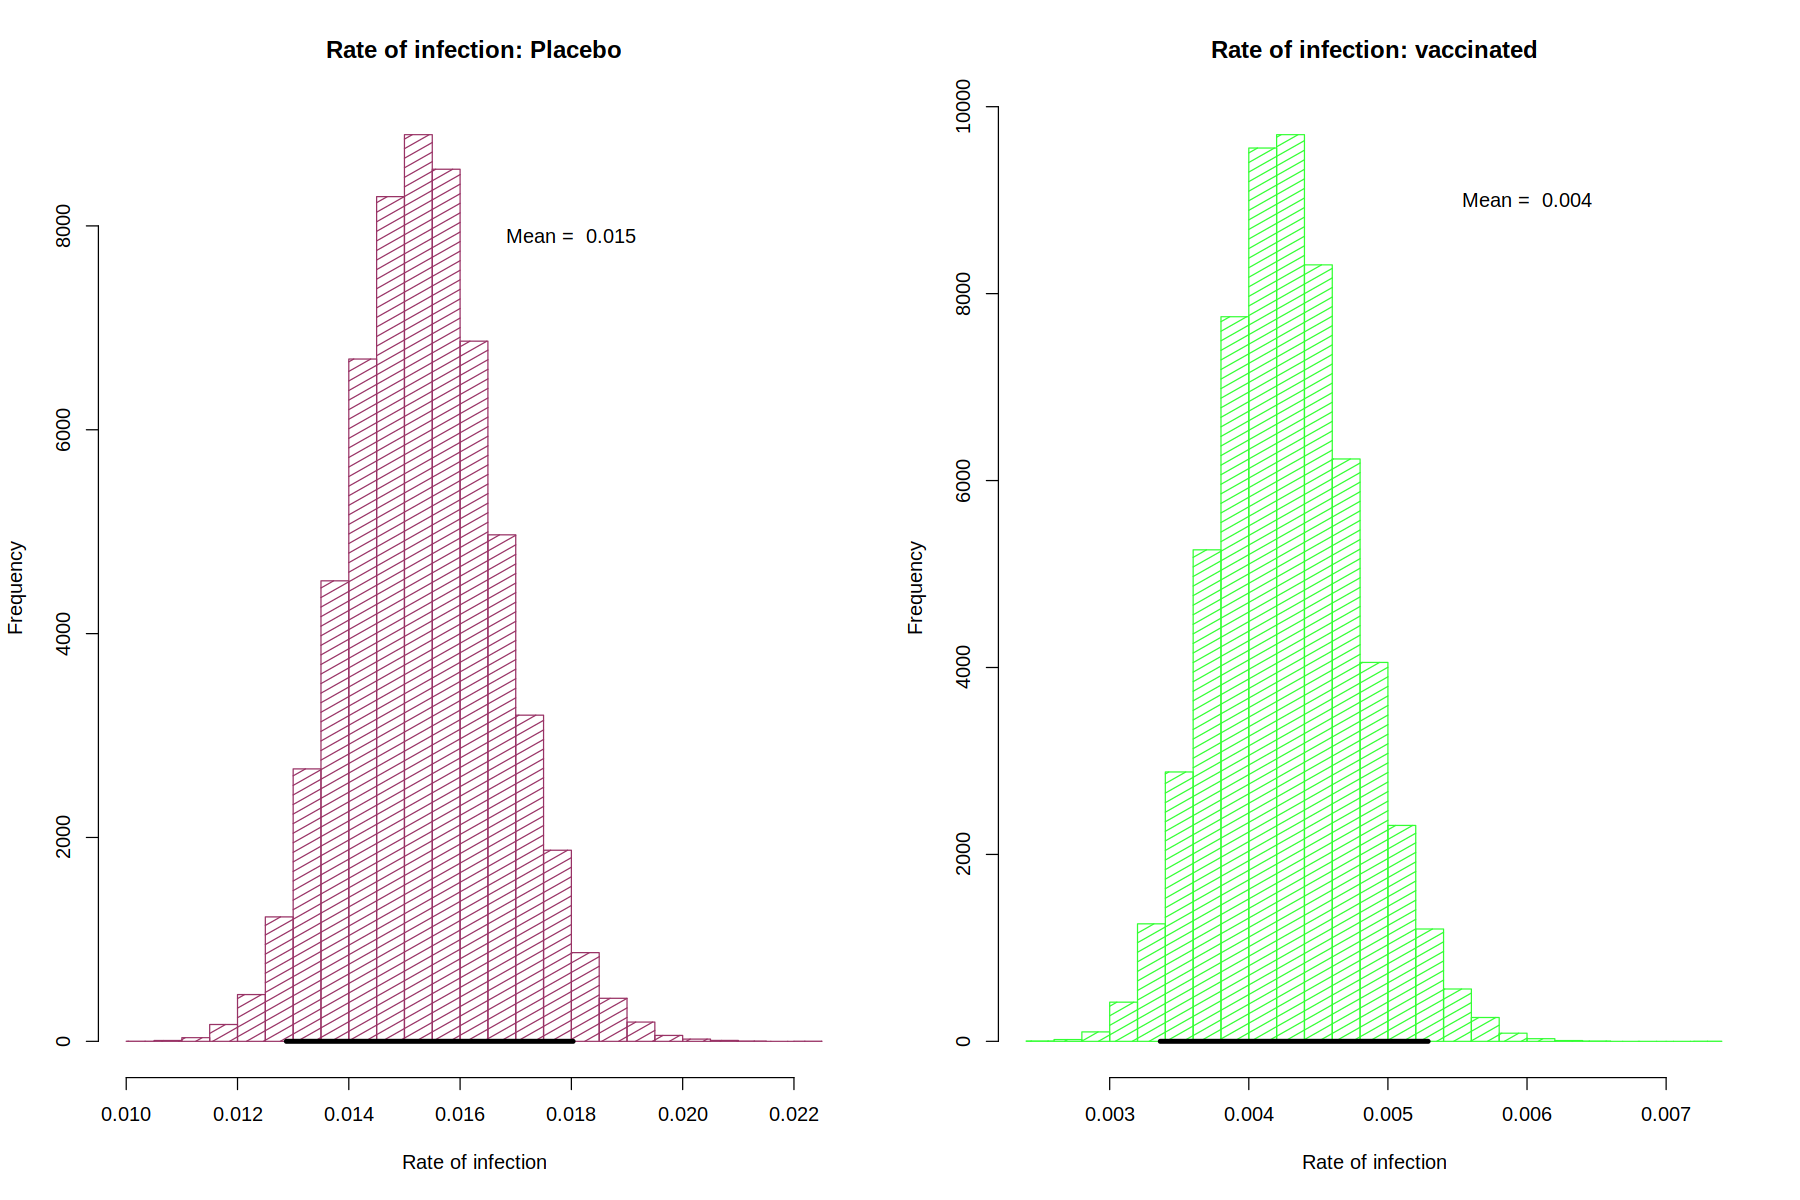

In [128]:
Vaxzeviria.chain.df <- as.data.frame ( as.mcmc( Vaxzeviria.chain ) )
placebo_V <- Vaxzeviria.chain.df[,1]
vaccine_V <- Vaxzeviria.chain.df[,2]

par(mfrow = c(1,2))  # Set up the layout for the plots
hist(placebo_V, breaks=26, main = "Rate of infection: Placebo", xlab = "Rate of infection", col = "#993366", density=30)
segments(quantile(placebo_V,0.025), 0, quantile(placebo_V,0.975), 0, col = "black", lwd =4)
text(0.018, 7900, paste('Mean = ',round(mean(placebo_V),3)), col = "black")

hist(vaccine_V, breaks=18, main = "Rate of infection: vaccinated", xlab = "Rate of infection", col = "#33FF33", density=30)
segments(quantile(vaccine_V,0.025), 0, quantile(vaccine_V,0.975), 0, col = "black", lwd =4)
text(0.006, 9000, paste('Mean = ',round(mean(vaccine_V),3)), col = "black")



*********************************************************************
Kruschke, J. K. (2015). Doing Bayesian Data Analysis, Second Edition:
A Tutorial with R, JAGS, and Stan. Academic Press / Elsevier.
*********************************************************************



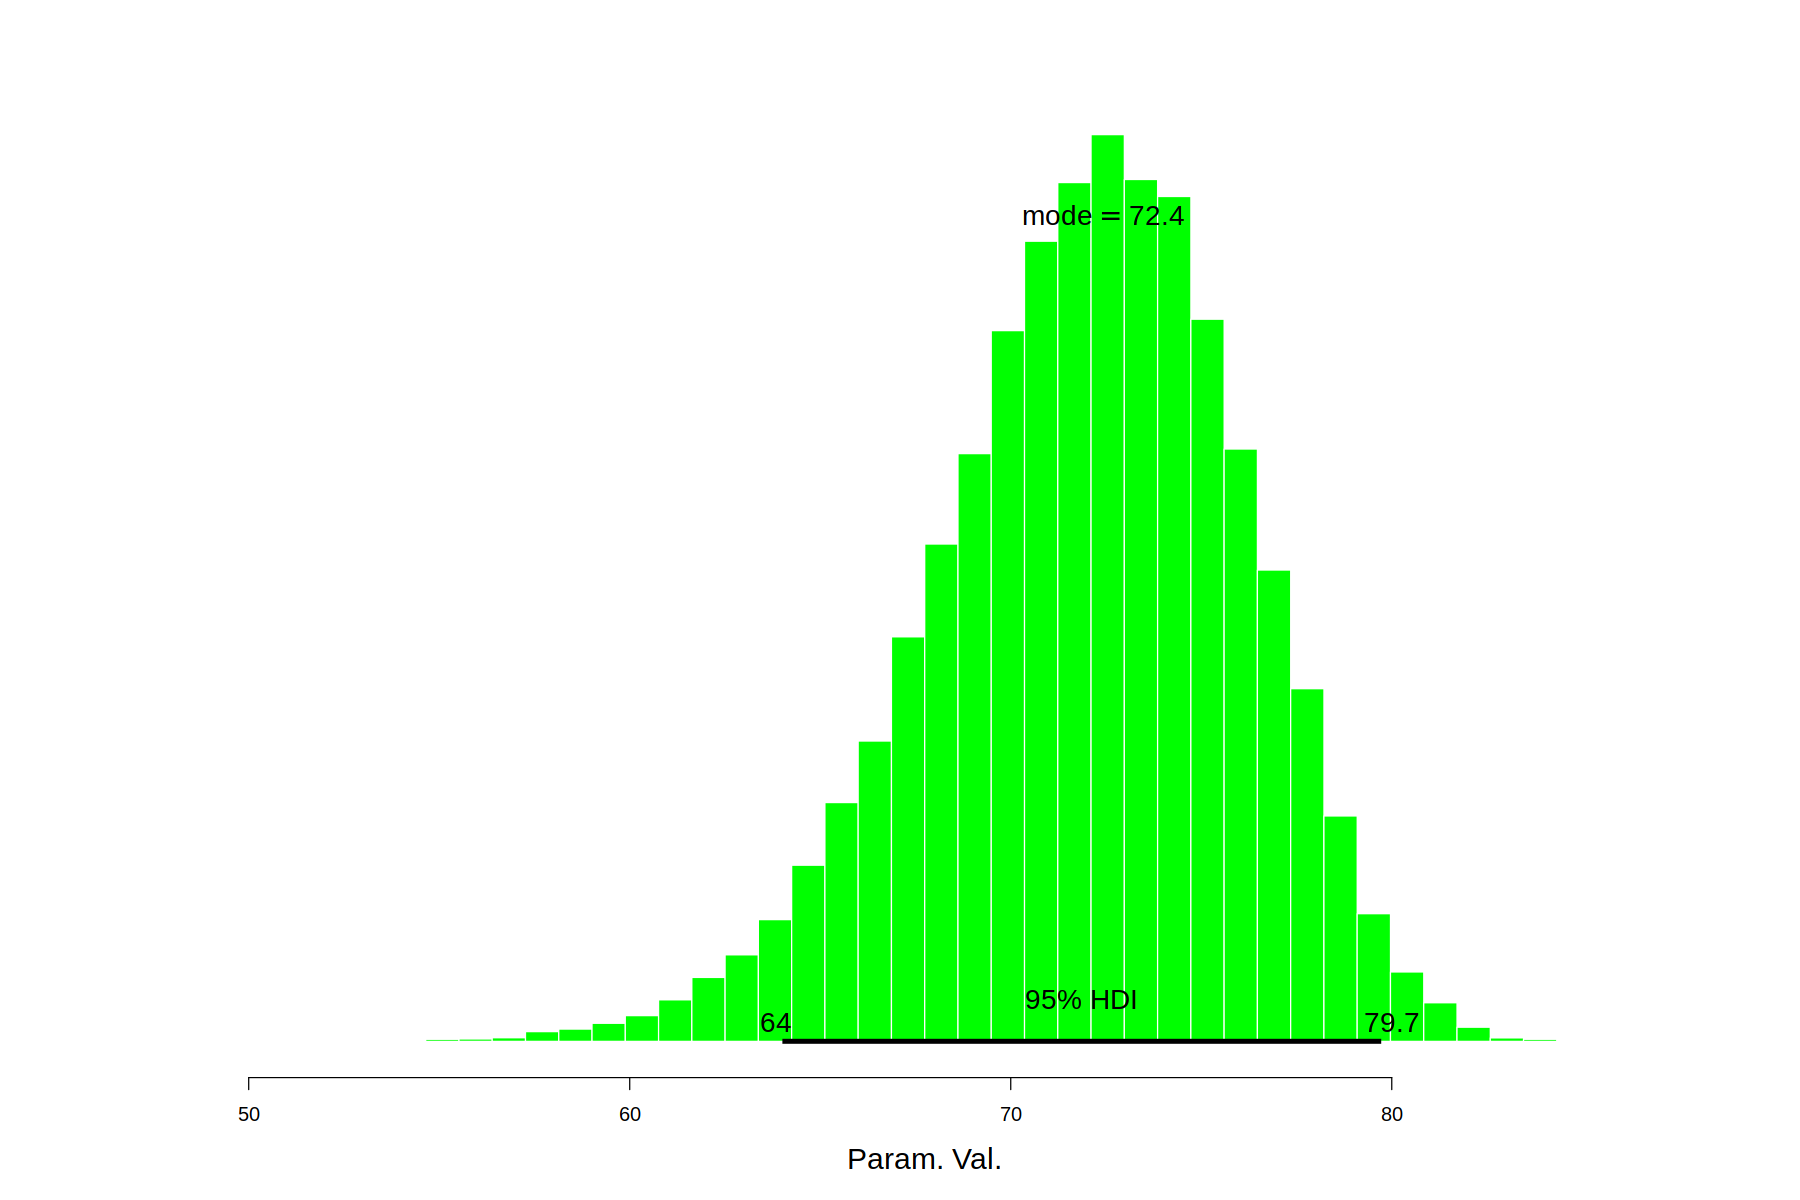

In [52]:
Vaxzeviria_res <- tidybayes::tidy_draws(Vaxzeviria.chain) %>%
  dplyr::select('theta[1]':'theta[2]') %>%
  dplyr::rename(Placebo = 'theta[1]', Vaccine = 'theta[2]') %>%
  dplyr::mutate(diff_rate = (Placebo - Vaccine) / Placebo * 100,
                Placebo_perc = Placebo * 100,
                Vaccine_perc = Vaccine * 100)

allmcmc2_V <- as.mcmc( Vaxzeviria_res , vars="diff_rate")
source("DBDA2E-utilities.R")
options(repr.plot.width = 15, repr.plot.height = 10)
pt3 <- plotPost( allmcmc2_V[,"diff_rate"],col= "green ")


## Janssen

In [46]:
Janssen <- get_data("J")
tot_vaccine <- Janssen$tot_vaccine  
tot_placebo <- Janssen$tot_placebo
pos_vaccine <- Janssen$pos_vaccine 
pos_placebo <- Janssen$pos_placebo

Janssen_organized <- organize_data(tot_vaccine, tot_placebo, pos_vaccine, pos_placebo) 
dataList_J <- Janssen_organized$dataList

Janssen.tb <- Janssen_organized$vax.tb
Ntot = nrow( Janssen.tb)
Nclass = nlevels ( factor ( Janssen.tb$patient ))

Janssen.chain <- run.jags( modelString , sample = 15000, n.chains = 4, method = "rjags", monitor = "theta", data = dataList_J )
summary ( Janssen.chain )

Compiling rjags model...
Calling the simulation using the rjags method...
Note: the model did not require adaptation
Burning in the model for 4000 iterations...
Running the model for 15000 iterations...
Simulation complete
Calculating summary statistics...
Calculating the Gelman-Rubin statistic for 2 variables....
Finished running the simulation


,Lower95,Median,Upper95,Mean,SD,Mode,MCerr,MC%ofSD,SSeff,AC.10,psrf
theta[1],0.015960764,0.017721406,0.019632665,0.017736165,0.0009374689,NA,4.686591e-06,0.5,40013,-0.0008885583,1.000018
theta[2],0.004946284,0.006020848,0.007099117,0.006033949,0.0005514510,NA,2.757255e-06,0.5,40000,0.0010065979,1.000011


Warning message in as.mcmc.runjags(Janssen.chain):
“Combining the 4 mcmc chains together”


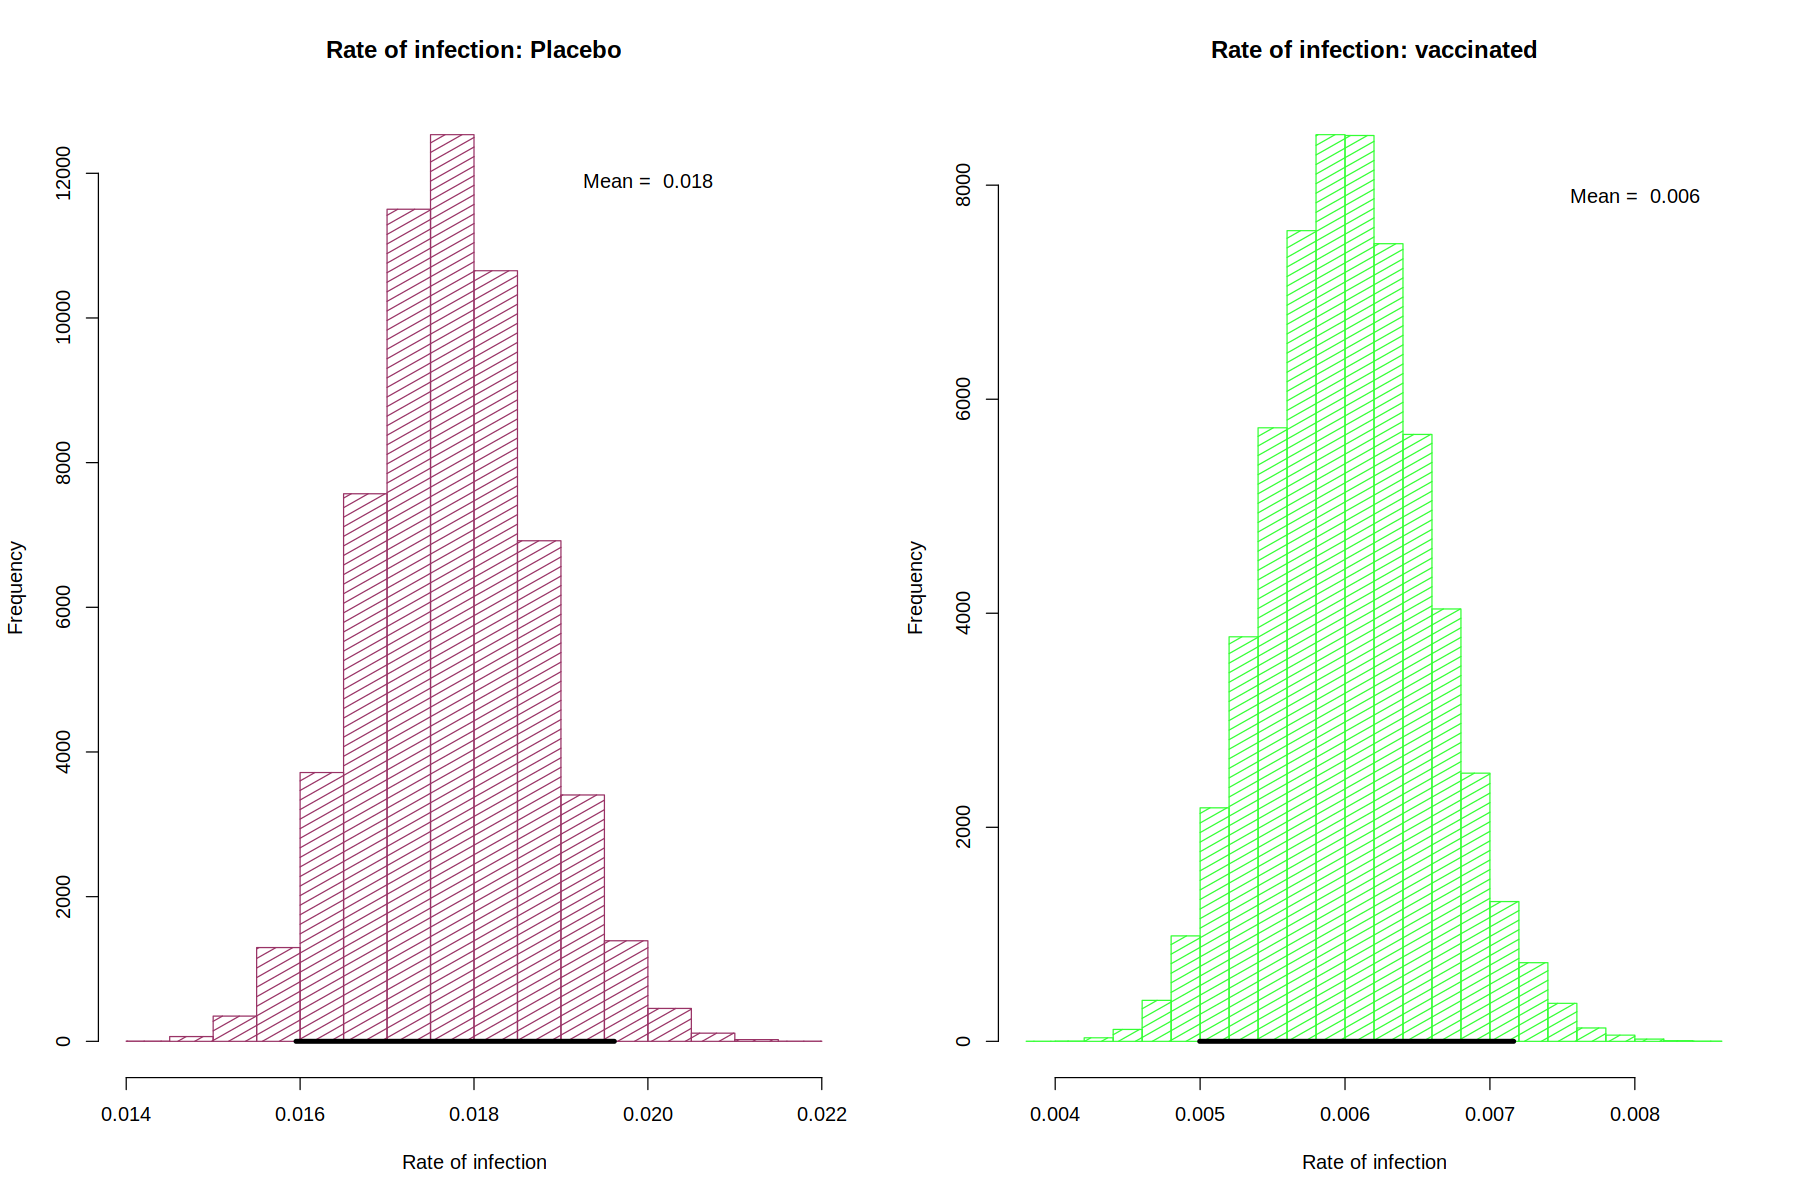

In [125]:
Janssen.chain.df <- as.data.frame ( as.mcmc( Janssen.chain ) )
placebo_J <- Janssen.chain.df[,1]
vaccine_J <- Janssen.chain.df[,2]

par(mfrow = c(1,2))  # Set up the layout for the plots
hist(placebo_J, breaks=26, main = "Rate of infection: Placebo", xlab = "Rate of infection", col = "#993366", density=30)
segments(quantile(placebo_J,0.025), 0, quantile(placebo_J,0.975), 0, col = "black", lwd =4)
text(0.02, 11900, paste('Mean = ',round(mean(placebo_J),3)), col = "black")

hist(vaccine_J, breaks=18, main = "Rate of infection: vaccinated", xlab = "Rate of infection", col = "#33FF33", density=30)
segments(quantile(vaccine_J,0.025), 0, quantile(vaccine_J,0.975), 0, col = "black", lwd =4)
text(0.008, 7900, paste('Mean = ',round(mean(vaccine_J),3)), col = "black")


In [70]:
hist(Janssen.chain$theta[1, , ], main = "Histogram of theta[1]", xlab = "theta[1]", col = "lightblue")

ERROR: Error in hist.default(Janssen.chain$theta[1, , ], main = "Histogram of theta[1]", : 'x' dev'essere numerico



*********************************************************************
Kruschke, J. K. (2015). Doing Bayesian Data Analysis, Second Edition:
A Tutorial with R, JAGS, and Stan. Academic Press / Elsevier.
*********************************************************************



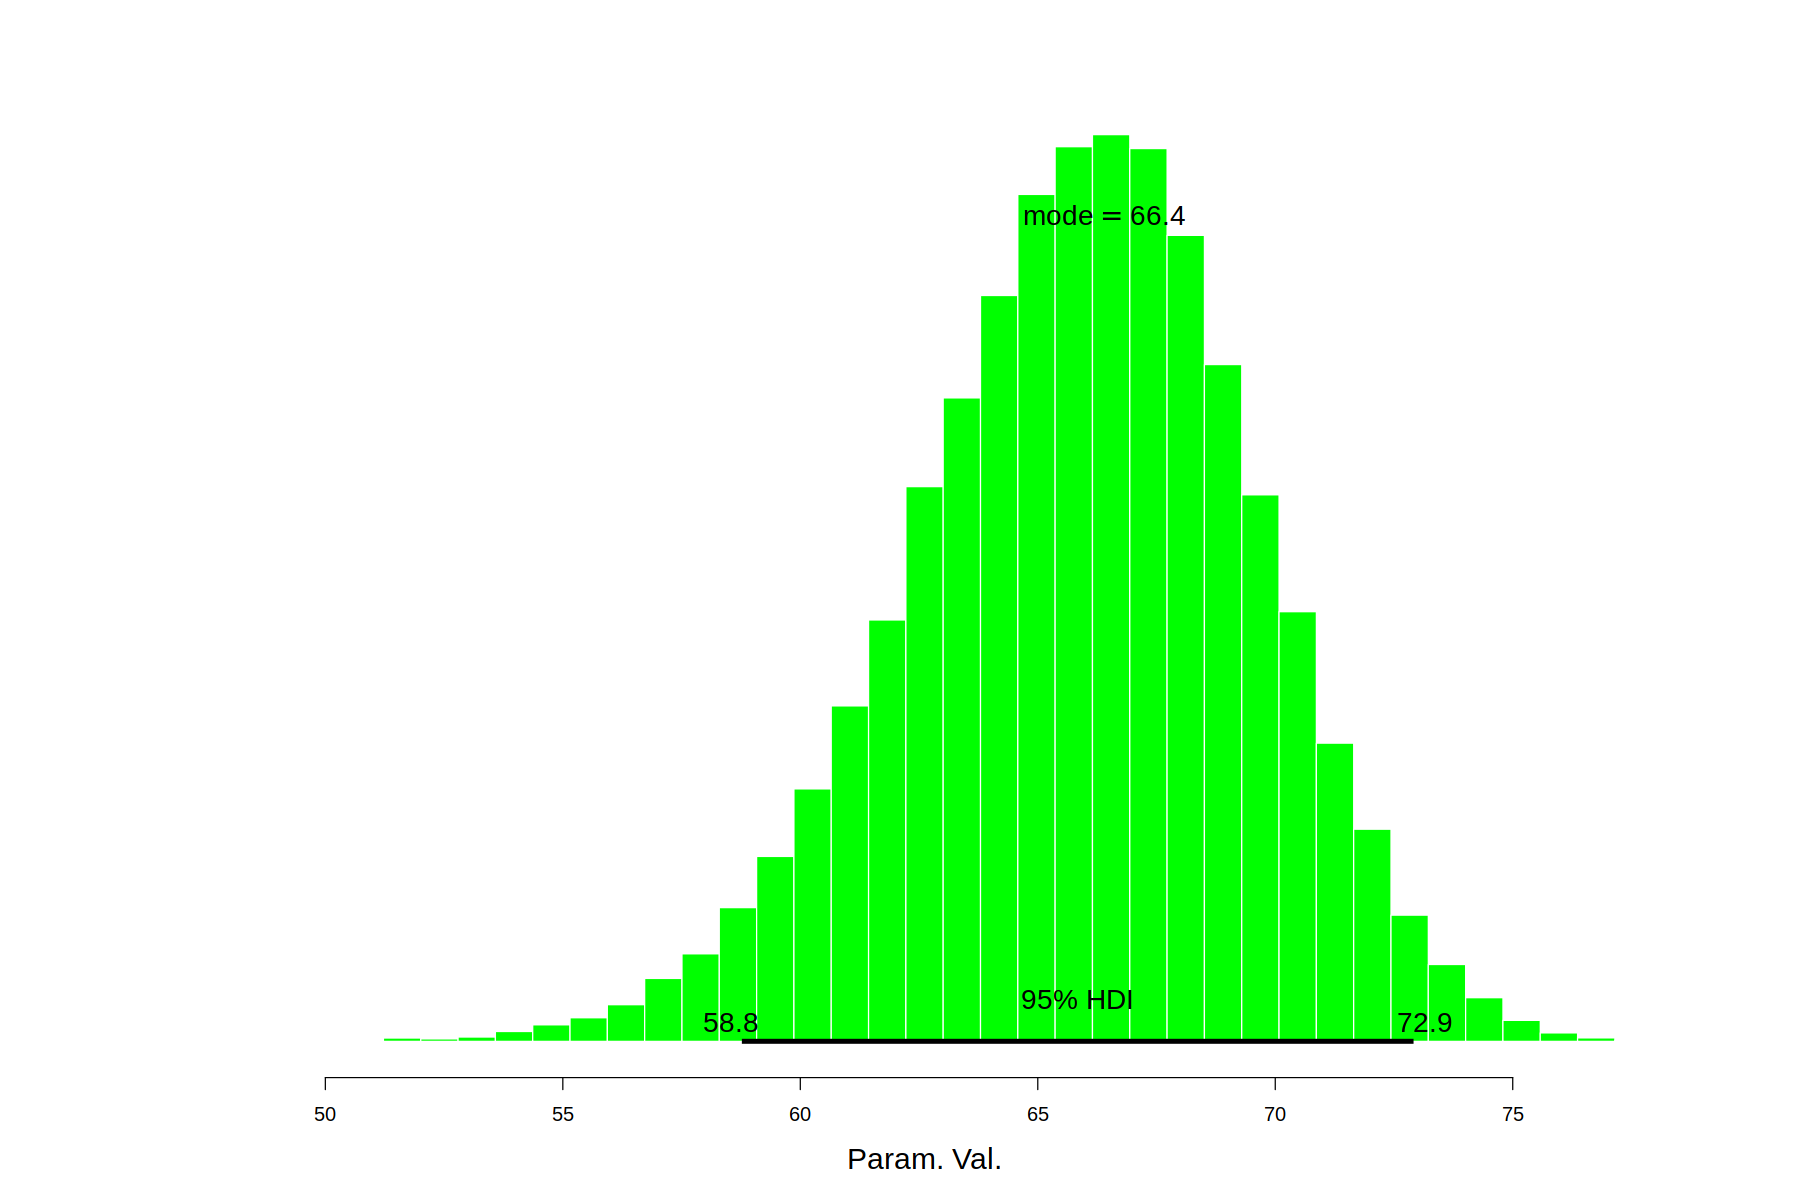

In [48]:
Janssen_res <- tidybayes::tidy_draws(Janssen.chain) %>%
  dplyr::select('theta[1]':'theta[2]') %>%
  dplyr::rename(Placebo = 'theta[1]', Vaccine = 'theta[2]') %>%
  dplyr::mutate(diff_rate = (Placebo - Vaccine) / Placebo * 100,
                Placebo_perc = Placebo * 100,
                Vaccine_perc = Vaccine * 100)

allmcmc2_J <- as.mcmc( Janssen_res , vars="diff_rate")
source("DBDA2E-utilities.R")
options(repr.plot.width = 15, repr.plot.height = 10)
pt3 <- plotPost( allmcmc2_J[,"diff_rate"],col= "green ")


## Moderna

In [50]:
Moderna <- get_data("J")
tot_vaccine <- Moderna$tot_vaccine  
tot_placebo <- Moderna$tot_placebo
pos_vaccine <- Moderna$pos_vaccine 
pos_placebo <- Moderna$pos_placebo

Moderna_organized <- organize_data(tot_vaccine, tot_placebo, pos_vaccine, pos_placebo) 
dataList_M<- Moderna_organized$dataList

Moderna.tb <- Moderna_organized$vax.tb
Ntot = nrow( Moderna.tb)
Nclass = nlevels ( factor ( Moderna.tb$patient ))

Moderna.chain <- run.jags( modelString , sample = 15000, n.chains = 4, method = "rjags", monitor = "theta", data = dataList_J )
summary ( Moderna.chain )

Compiling rjags model...
Calling the simulation using the rjags method...
Note: the model did not require adaptation
Burning in the model for 4000 iterations...
Running the model for 15000 iterations...
Simulation complete
Calculating summary statistics...
Calculating the Gelman-Rubin statistic for 2 variables....
Finished running the simulation


,Lower95,Median,Upper95,Mean,SD,Mode,MCerr,MC%ofSD,SSeff,AC.10,psrf
theta[1],0.015876784,0.017707974,0.019530536,0.017728387,0.0009353829,NA,4.623214e-06,0.5,40935,0.003184400,1.000039
theta[2],0.004956412,0.006009931,0.007110567,0.006028861,0.0005529213,NA,2.764607e-06,0.5,40000,-0.007481113,1.000072


Warning message in as.mcmc.runjags(Moderna.chain):
“Combining the 4 mcmc chains together”


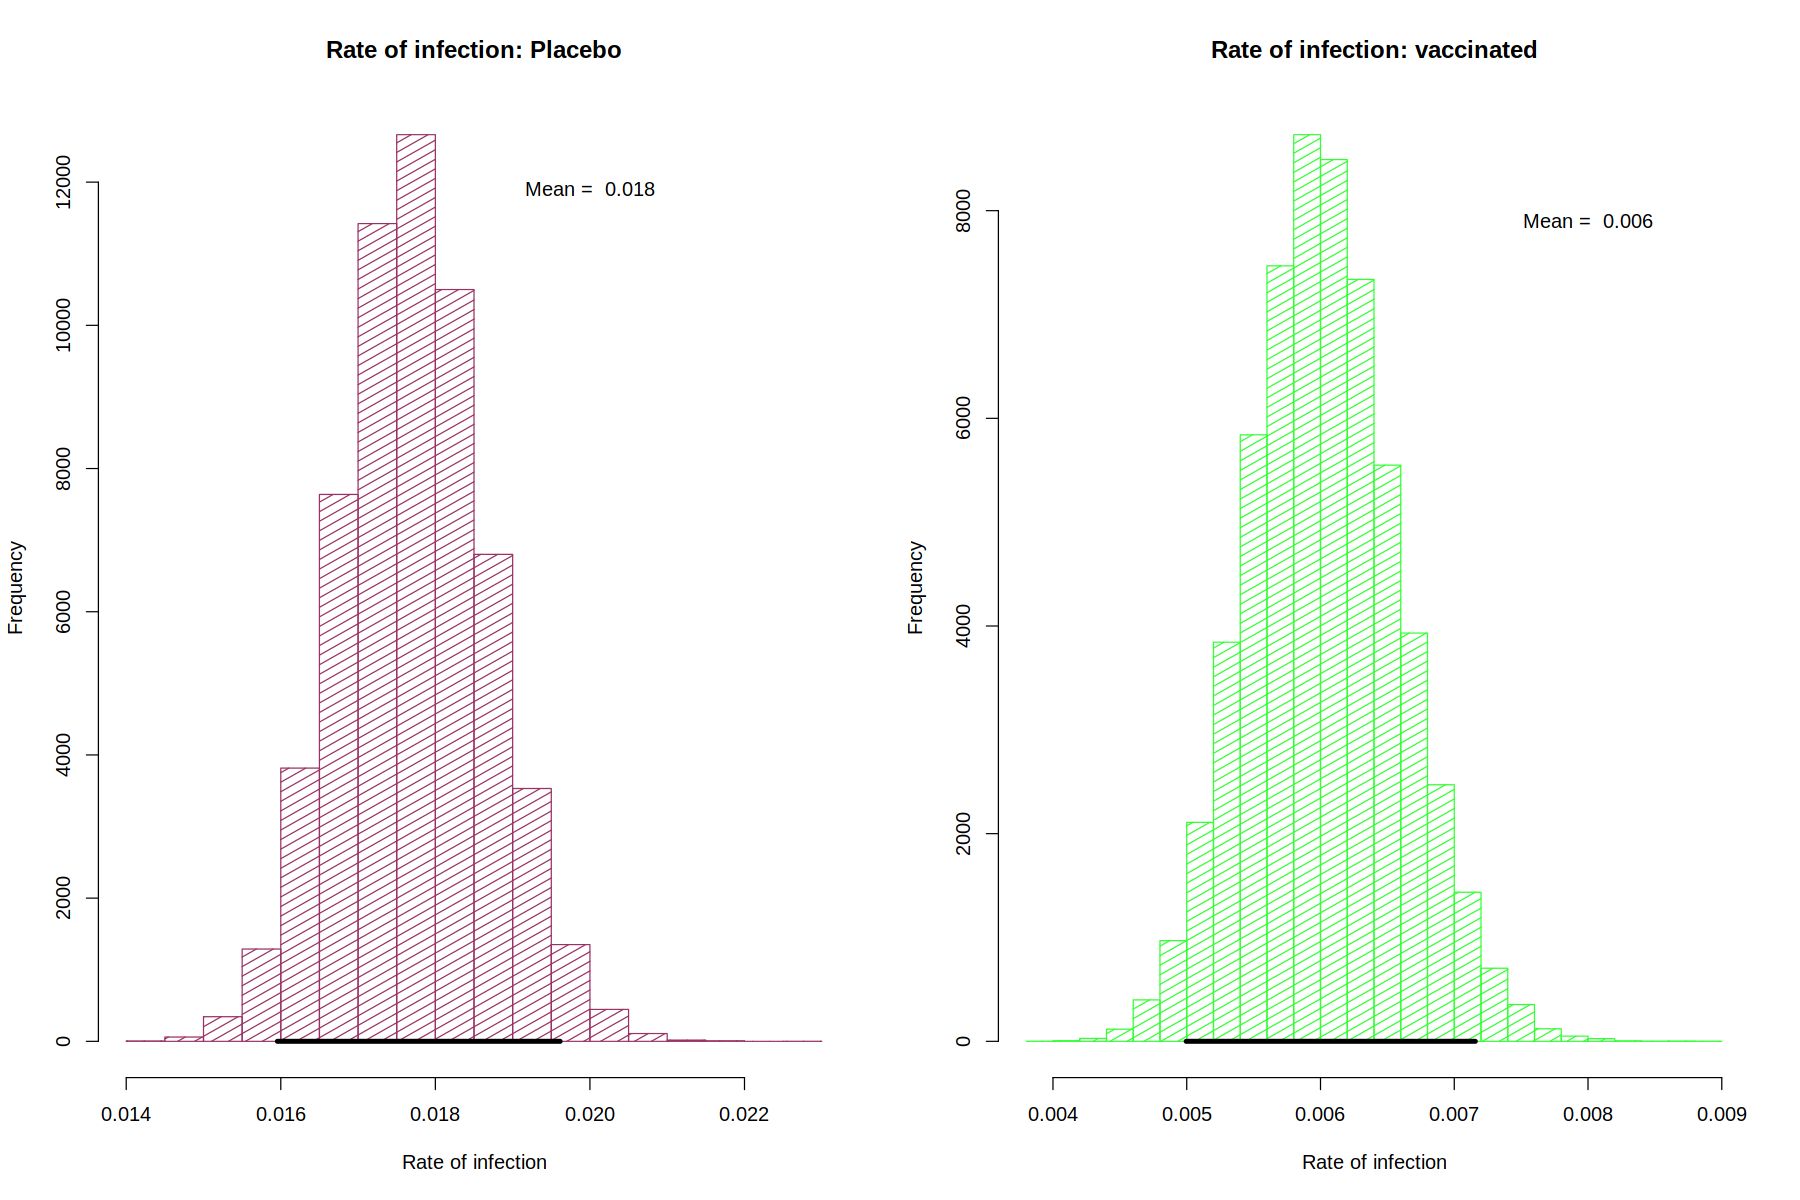

In [129]:
Moderna.chain.df <- as.data.frame ( as.mcmc(Moderna.chain ) )
placebo_M <- Moderna.chain.df[,1]
vaccine_M <- Moderna.chain.df[,2]

par(mfrow = c(1,2))  # Set up the layout for the plots
hist(placebo_M, breaks=26, main = "Rate of infection: Placebo", xlab = "Rate of infection", col = "#993366", density=30)
segments(quantile(placebo_M,0.025), 0, quantile(placebo_M,0.975), 0, col = "black", lwd =4)
text(0.02, 11900, paste('Mean = ',round(mean(placebo_M),3)), col = "black")

hist(vaccine_M, breaks=18, main = "Rate of infection: vaccinated", xlab = "Rate of infection", col = "#33FF33", density=30)
segments(quantile(vaccine_M,0.025), 0, quantile(vaccine_M,0.975), 0, col = "black", lwd =4)
text(0.008, 7900, paste('Mean = ',round(mean(vaccine_M),3)), col = "black")



*********************************************************************
Kruschke, J. K. (2015). Doing Bayesian Data Analysis, Second Edition:
A Tutorial with R, JAGS, and Stan. Academic Press / Elsevier.
*********************************************************************



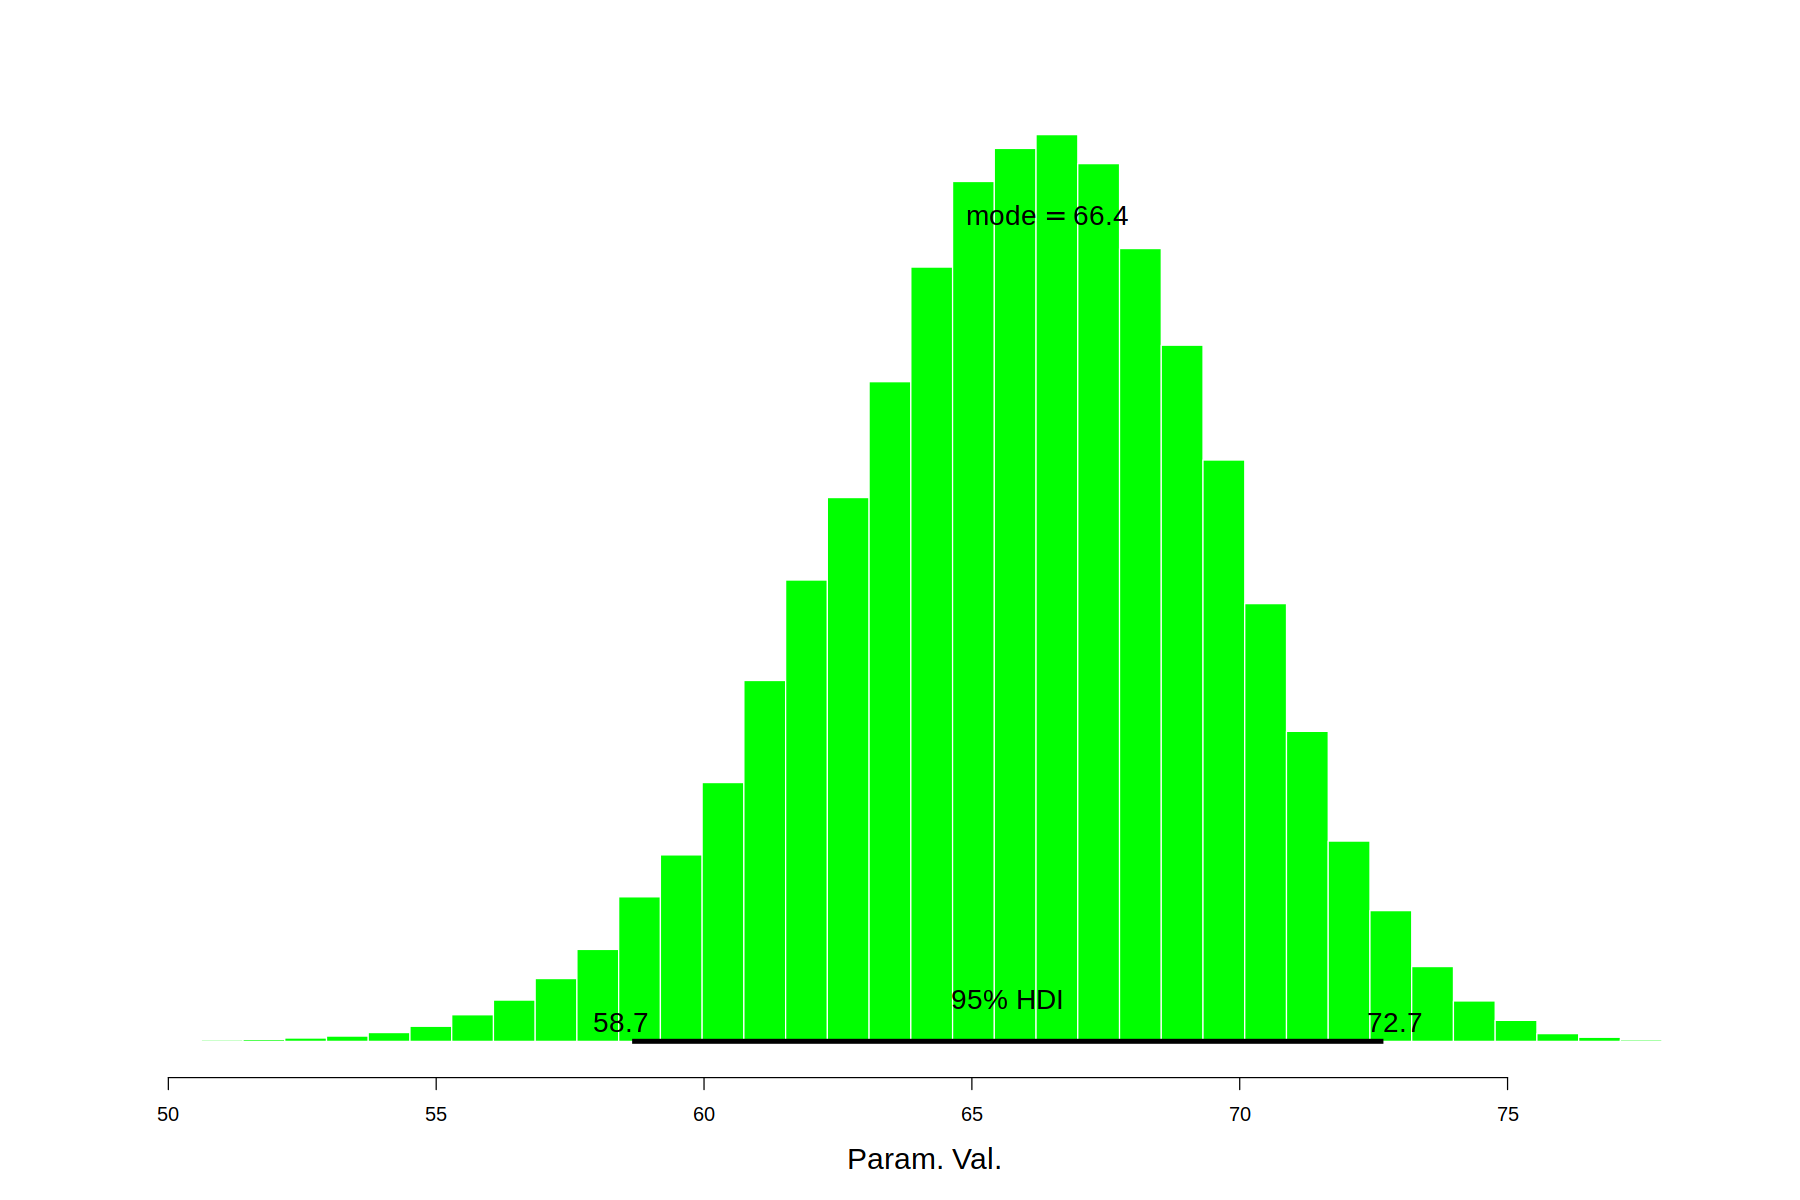

In [51]:
Moderna_res <- tidybayes::tidy_draws(Moderna.chain) %>%
  dplyr::select('theta[1]':'theta[2]') %>%
  dplyr::rename(Placebo = 'theta[1]', Vaccine = 'theta[2]') %>%
  dplyr::mutate(diff_rate = (Placebo - Vaccine) / Placebo * 100,
                Placebo_perc = Placebo * 100,
                Vaccine_perc = Vaccine * 100)

allmcmc2_M <- as.mcmc(Moderna_res , vars="diff_rate")
source("DBDA2E-utilities.R")
options(repr.plot.width = 15, repr.plot.height = 10)
pt3 <- plotPost( allmcmc2_M[,"diff_rate"],col= "green ")


## Exercise 3
• according to the official COVID-19 vaccination data, 70% of the world population has received at
least one dose of a COVID-19 vaccine. A global vaccination dataset is available [5]
• the European Centre for Disease Prevention and Control published a downloadable file [6] containing
information on COVID-19 vaccination in the EU/EEA.
• analyze the data and produce the following plots:
- number of vaccinated people (cumulative, daily and week average)
- number of confirmed deaths by COVID-19, both cumulative and weekly average